# **Movies Dataset Analysis**

## **Collaborators** 
- Ashna Sood 
- Urmi Suresh
- Tae Kim 
- Xianglong Wang

## **Imports** 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os 
import pickle
import math

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import make_scorer, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer

from sklearn import metrics

# from google.colab import drive
# from google.colab import files

In [2]:
# mount Google Drive to save results
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# upload a kaggle api key and set it to be used
# files.upload()
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# use the kaggle api to download the dataset we'll be using
# !kaggle datasets download -d rounakbanik/the-movies-dataset
# !unzip the-movies-dataset.zip

 92% 209M/228M [00:07<00:00, 20.4MB/s]
100% 228M/228M [00:07<00:00, 31.9MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


## **Data Cleaning**

In [3]:
# read in movies metadata 
movies_df = pd.read_csv('Movies Data/movies_metadata.csv')

# drop unecessary metadata
movies_df = movies_df.drop(columns=["adult", "budget", "homepage", "original_title", "overview", "poster_path", "status", "tagline", "video"])


# change column names
movies_df = movies_df.rename(columns={"belongs_to_collection":"Collection", 
                                      "genres":"Genres", 
                                      "id":"ID", 
                                      "imdb_id":"IMDB ID", 
                                      "original_language":"Language", 
                                      "popularity":"Popularity Rating", 
                                      "production_companies":"Production Companies", 
                                      "production_countries":"Production Countries", 
                                      "release_date":"Release Date", 
                                      "revenue":"Revenue", "runtime":"Runtime", 
                                      "spoken_languages":"Spoken Languages", 
                                      "title":"Title", 
                                      "vote_average":"Vote Average", 
                                      "vote_count":"Vote Count"})

# remove duplicate movies present in the df keeping the movie with a higher vote count
movies_df = movies_df.sort_values('Vote Count').drop_duplicates('Title', keep='last')

# reorder columns 
movies_df = movies_df[["ID", "IMDB ID", "Title", "Collection", "Genres", "Language", "Spoken Languages", "Release Date", 
                       "Runtime", "Revenue", "Production Companies", "Production Countries", 
                       "Popularity Rating", "Vote Count", "Vote Average"]]

movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average
45465,461257,tt6980792,Queerama,NaN,[],en,"[{'iso_639_1': 'en', 'name': 'English'}]",2017-06-09,75.0,0.000000e+00,[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.163015,0.0,0.0
23677,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,0.000000e+00,[],[],0.3265,0.0,0.0
23671,114838,tt0029949,Brother Rat,NaN,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'iso_639_1': 'en', 'name': 'English'}]",1938-10-29,87.0,0.000000e+00,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.174691,0.0,0.0
23663,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,0.000000e+00,[],[],0.000115,0.0,0.0
23648,88061,tt0055459,"So Evil, So Young",NaN,"[{'id': 18, 'name': 'Drama'}]",en,"[{'iso_639_1': 'en', 'name': 'English'}]",1963-01-01,77.0,0.000000e+00,[],[],0.001662,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17818,24428,tt0848228,The Avengers,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"[{'iso_639_1': 'en', 'name': 'English'}]",2012-04-25,143.0,1.519558e+09,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",89.8876,12000.0,7.4
14551,19995,tt0499549,Avatar,"{'id': 87096, 'name': 'Avatar Collection', 'po...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2009-12-10,162.0,2.787965e+09,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",185.071,12114.0,7.2
12481,155,tt0468569,The Dark Knight,"{'id': 263, 'name': 'The Dark Knight Collectio...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2008-07-16,152.0,1.004558e+09,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",123.167,12269.0,8.3
15480,27205,tt1375666,Inception,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,"[{'iso_639_1': 'en', 'name': 'English'}]",2010-07-14,148.0,8.255328e+08,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",29.1081,14075.0,8.1


In [4]:
# read in movie keywords
keywords_df = pd.read_csv('Movies Data/keywords.csv')

# rename columns
keywords_df = keywords_df.rename(columns={"id": "ID", 
                                          "keywords": "Keywords"})

In [5]:
# read in movie credits 
credits_df = pd.read_csv('Movies Data/credits.csv')

# rename columns
credits_df = credits_df.rename(columns={"cast": "Cast", 
                                        "crew": "Crew",
                                        "id": "ID"})

In [6]:
# merge tables
movies_df['ID'] = movies_df['ID'].astype(str)
keywords_df['ID'] = keywords_df['ID'].astype(str)
credits_df['ID'] = credits_df['ID'].astype(str)

movies_df = movies_df.merge(keywords_df, on="ID", how="left").merge(credits_df, on="ID", how="left")
movies_df.head(1)

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Crew
0,461257,tt6980792,Queerama,NaN,[],en,"[{'iso_639_1': 'en', 'name': 'English'}]",2017-06-09,75.0,0.0,[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.163015,0.0,0.0,[],[],"[{'credit_id': '593e676c92514105b702e68e', 'de..."


In [7]:
# cast types
movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'], errors='coerce')
movies_df['Popularity Rating'] = pd.to_numeric(movies_df['Popularity Rating'], errors='coerce')
movies_df['Vote Count'] = movies_df['Vote Count'].astype(np.int64, errors='ignore')

# replace unreasonable values with NaN
movies_df['Revenue'] = movies_df['Revenue'].replace(0, np.nan)
movies_df['Popularity Rating'] = movies_df['Popularity Rating'].replace(0, np.nan)
movies_df['Vote Count'] = movies_df['Vote Count'].replace(0, np.nan)
movies_df['Vote Average'] = movies_df['Vote Average'].replace(0, np.nan)

In [8]:
# method to extract the director, screenplay writer, and producer from each movie
def extract_crew(crew):
    director, writer, producer = None, None, None
    for each in crew:

        if director and writer and producer:
            return [director, writer, producer]

        try:
            if (not director) and each['department']=='Directing' and each['job']=='Director':
                director = each['name']
                continue
                
        except:
          ...

        try:
            if (not writer) and each['department']=='Writing' and each['job']=='Screenplay' or each['job']=='Writer':
                writer = each['name']
                continue
        except:
            ...

        try:
            if (not producer) and each['department']=='Production' and (each['job']=='Producer' or each['job']=='Executive Producer'):
                producer = each['name']
                continue
        except:
            ...

    return [director, writer, producer]

In [9]:
# convert the Collections string literal into a dict and extract the name of the franchise 
movies_df["Collection"] = movies_df['Collection'].fillna('[]').apply(ast.literal_eval).apply(lambda x: x["name"] if isinstance(x, dict) else np.nan)

# extract genres out of string literal
movies_df['Genres'] = movies_df['Genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract spoken languages out of string literal
movies_df['Spoken Languages'] = movies_df['Spoken Languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else np.nan)

# extract Production Company out of string literal
movies_df['Production Companies'] = movies_df['Production Companies'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract Production Countries out of string literal
movies_df['Production Countries'] = movies_df['Production Countries'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract the keywords for each movie
movies_df["Keywords"] = movies_df["Keywords"].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract the names of at most the top 5 actors in each movie
movies_df["Cast"] = movies_df["Cast"].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)
movies_df["Cast"] = movies_df["Cast"].apply(lambda x: x[:5] if len(x) > 5 else x)

# conver the Crew string literal into dict and extract the director, screenplay writer, and producer of each movie 
movies_df["Crew"] = movies_df["Crew"].fillna('[]').apply(ast.literal_eval)
movies_df['Director'], movies_df['Writer'], movies_df['Producer'] = [*zip(*np.array(movies_df['Crew'].apply(extract_crew)))]
movies_df = movies_df.drop('Crew', axis=1)

movies_df = movies_df.fillna(value=np.nan)

movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan


## **EDA**

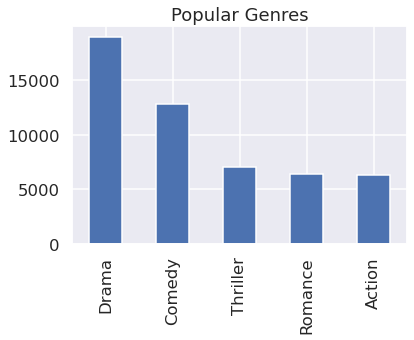

In [81]:
# see the top 5 genres in the dataset
genre_counts = pd.Series(movies_df['Genres'].sum()).value_counts()
genre_counts.head(5).plot(kind='bar', title='Popular Genres')

In [82]:
# count NaN in each column
movies_df.isna().sum()

# Collection: most movies don't belong to a series 
# Revenue: missing data

ID                          0
IMDB ID                    14
Title                       1
Collection              38815
Genres                      0
Language                   11
Spoken Languages            0
Release Date               84
Runtime                   258
Revenue                 35997
Production Companies        1
Production Countries        1
Popularity Rating          67
Vote Count               2756
Vote Average             2844
Keywords                    0
Cast                        0
Director                  889
Writer                   9822
Producer                21552
dtype: int64

In [83]:
# see various languages movies were shot in
# mainly movies in English 
movies_df["Language"].value_counts().head(5)

en    30567
fr     2347
it     1496
ja     1341
de     1029
Name: Language, dtype: int64

In [84]:
# franchise movies
movies_fran = movies_df[movies_df['Collection'].notnull()]
'%d many movies belong to a collection' % movies_fran.shape[0]

'4436 many movies belong to a collection'

In [85]:
# revenue by collection
movies_fran_pivot = movies_fran.pivot_table(index='Collection', values='Revenue', aggfunc={'Revenue': [np.mean, np.sum, 'count']})
movies_fran_pivot = movies_fran_pivot.sort_values('sum', ascending=False).reset_index()
movies_fran_pivot.head(20)

,Collection,count,mean,sum
0,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1,Star Wars Collection,8,9.293118e+08,7.434495e+09
2,James Bond Collection,25,2.826090e+08,7.065226e+09
3,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
4,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
5,Transformers Collection,5,8.732202e+08,4.366101e+09
6,Despicable Me Collection,4,9.227676e+08,3.691070e+09
7,The Twilight Collection,5,6.684215e+08,3.342107e+09
8,Ice Age Collection,5,6.433417e+08,3.216709e+09
9,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


In [86]:
# popularity rating 
movies_fran_pivot2 = movies_fran.pivot_table(index='Collection', values='Popularity Rating', aggfunc={'Popularity Rating': [np.mean, np.sum]})
movies_fran_pivot2 = movies_fran_pivot2.sort_values('sum', ascending=False).reset_index()
movies_fran_pivot2.head(20)

,Collection,mean,sum
0,Despicable Me Collection,106.715961,640.295768
1,James Bond Collection,13.459622,336.490544
2,Wonder Woman Collection,294.337037,294.337037
3,Pirates of the Caribbean Collection,53.972237,269.861183
4,Planet of the Apes (Reboot) Collection,87.720253,263.160759
5,Guardians of the Galaxy Collection,119.311296,238.622593
6,John Wick Collection,116.558939,233.117879
7,The Hunger Games Collection,54.766748,219.066990
8,Harry Potter Collection,26.253893,210.031146
9,Avatar Collection,95.545473,191.090947


## **Content Based Recommender System**

In [10]:
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan


In [11]:
# clean up keywords 
keywords = movies_df.apply(lambda x: pd.Series(x["Keywords"]), axis = 1).stack().reset_index(level = 1, drop = True)
keywords = keywords.value_counts()
keywords = keywords[keywords >= 3]
keywords

# check the distribution and see if you increased the threshold how many keywords would you lose
# start with maybe seeing what keywords are present with a threshold of at least 50

woman director      2904
independent film    1825
murder              1201
based on novel       761
musical              681
                    ... 
любовь                 3
part of trilogy        3
theology               3
ruler                  3
chernobyl              3
Length: 7986, dtype: int64

In [12]:
def select_keywords(words):
  final_words = []
  for word in words:
    if word in keywords:
      final_words.append(word)
  return final_words

In [13]:
# only keep keywords that have frequency greater than 3
movies_df["Keywords"] = movies_df["Keywords"].apply(select_keywords).apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [14]:
# Collection - remove whitespace and convert to lowercase 
movies_df["Collection"] = movies_df["Collection"].str.lower().str.replace(" ", "")

# Cast - remove whitespace and convert to lowercase 
movies_df["Cast"] = movies_df["Cast"].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# Director - remove whitespace and convert to lowercase 
movies_df["Director"] = movies_df["Director"].str.lower().str.replace(" ", "")

# Writer - remove whitespace and convert to lowercase 
movies_df["Writer"] = movies_df["Writer"].str.lower().str.replace(" ", "")

# Producer - remove whitespace and convert to lowercase 
movies_df["Producer"] = movies_df["Producer"].str.lower().str.replace(" ", "")

In [15]:
# replace NAN with empty space 
movies_df["Collection"] = movies_df["Collection"].fillna('')
movies_df["Director"] = movies_df["Director"].fillna('')
movies_df["Writer"] = movies_df["Writer"].fillna('')
movies_df["Producer"] = movies_df["Producer"].fillna('')

In [16]:
# experimenting with giving more weight to director -- if don't want comment this line
#movies_df["Director"] = movies_df["Director"].apply(lambda x: f"{x} {x} {x}")

# combine all string metadata
movies_df["Metadata"] = movies_df["Director"] + " " + movies_df["Writer"] + " " + movies_df["Producer"] + " " + movies_df["Collection"]

# combine list metadata
movies_df["Metadata2"] = movies_df["Genres"] + movies_df["Cast"] + movies_df["Keywords"]
movies_df["Metadata2"] = movies_df["Metadata2"].apply(lambda x: " ".join(x))

# merge all metadata to one column 
movies_df["Metadata"] = movies_df["Metadata"] + movies_df["Metadata2"]
# drop second metadata col
movies_df = movies_df.drop(columns=["Metadata2"])
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
0,461257,tt6980792,Queerama,,[],en,[en],2017-06-09,75.0,NaN,...,[United Kingdom],0.163015,NaN,NaN,[],[],daisyasquith,,,daisyasquith
1,92323,tt0081758,Willie and Phil,,[],en,[],1980-08-15,115.0,NaN,...,[],0.326500,NaN,NaN,[],"[michaelontkean, raysharkey, margotkidder]",paulmazursky,paulmazursky,,paulmazursky paulmazursky michaelontkean rays...
2,114838,tt0029949,Brother Rat,,[Comedy],en,[en],1938-10-29,87.0,NaN,...,[United States of America],0.174691,NaN,NaN,[basedonplayormusical],"[ronaldreagan, janewyman, priscillalane, wayne...",williamkeighley,jerrywald,,williamkeighley jerrywald Comedy ronaldreagan...
3,264723,tt0070580,Le pélican,,[],en,[],1974-02-06,83.0,NaN,...,[],0.000115,NaN,NaN,[],[],gérardblain,,,gérardblain
4,88061,tt0055459,"So Evil, So Young",,[Drama],en,[en],1963-01-01,77.0,NaN,...,[],0.001662,NaN,NaN,"[prison, women'sprison]","[jillireland, ellenpollock, joanhaythorne, oli...",godfreygrayson,markgrantham,,godfreygrayson markgrantham Drama jillireland...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,theavengerscollection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,...,[United States of America],89.887648,12000.0,7.4,"[newyork, shield, marvelcomic, superhero, base...","[robertdowneyjr., chrisevans, markruffalo, chr...",josswhedon,josswhedon,stanlee,josswhedon josswhedon stanlee theavengerscolle...
43247,19995,tt0499549,Avatar,avatarcollection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,...,"[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[cultureclash, future, spacewar, spacecolony, ...","[samworthington, zoesaldana, sigourneyweaver, ...",jamescameron,jamescameron,jamescameron,jamescameron jamescameron jamescameron avatarc...
43248,155,tt0468569,The Dark Knight,thedarkknightcollection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,...,"[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dccomics, crimefighter, secretidentity, scare...","[christianbale, michaelcaine, heathledger, aar...",christophernolan,christophernolan,charlesroven,christophernolan christophernolan charlesroven...
43249,27205,tt1375666,Inception,,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,...,"[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[lossoflover, dream, kidnapping, sleep, subcon...","[leonardodicaprio, josephgordon-levitt, ellenp...",christophernolan,christophernolan,christophernolan,christophernolan christophernolan christophern...


In [ ]:
# took the parameters and ran PCA on it and job to reduce the dimensionality 
# feed the individual columns into the PCA model -- can see what the natural most fitting combinations are 
# better to have model figure out the weights and correlations 

In [17]:
duplicate = movies_df[movies_df.duplicated(subset=["Title"])] 
duplicate

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
585,187156,tt1515157,Jean-Luc Cinema Godard,,[Documentary],en,"[fr, en]",2009-09-30,24.0,NaN,...,[United Kingdom],0.004841,NaN,NaN,[],[],shaneo'sullivan,shaneo'sullivan,,shaneo'sullivan shaneo'sullivan Documentary
1354,99080,tt0022537,The Viking,,"[Action, Drama, Romance, Adventure]",en,[en],1931-06-21,70.0,NaN,...,[],0.002362,NaN,NaN,[],"[charlesstarrett, louisehuntington, arthurvint...",varickfrissell,,,varickfrissell Action Drama Romance Adventur...
1355,99080,tt0022537,The Viking,,"[Action, Drama, Romance, Adventure]",en,[en],1931-06-21,70.0,NaN,...,[],0.002362,NaN,NaN,[],"[charlesstarrett, louisehuntington, arthurvint...",georgemelford,,,georgemelford Action Drama Romance Adventure...
1356,99080,tt0022537,The Viking,,"[Action, Drama, Romance, Adventure]",en,[en],1931-06-21,70.0,NaN,...,[],0.002362,NaN,NaN,[],"[charlesstarrett, louisehuntington, arthurvint...",varickfrissell,,,varickfrissell Action Drama Romance Adventur...
2203,314283,tt4276834,A Perfect Christmas List,,"[Comedy, Drama, Family]",en,"[en, fr]",2014-12-14,86.0,NaN,...,[United States of America],0.605492,NaN,NaN,[christmas],"[ellenhollman, bethbroderick, aaronhill, richa...",fredolenray,petersullivan,,fredolenray petersullivan Comedy Drama Family...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42595,140300,tt2267968,Kung Fu Panda 3,kungfupandacollection,"[Action, Adventure, Animation, Comedy, Family]",en,[en],2016-01-23,95.0,5.211708e+08,...,"[China, United States of America]",14.696548,1630.0,6.7,"[china, martialarts, kungfu, village, panda, s...","[jackblack, bryancranston, dustinhoffman, ange...",jenniferyuhnelson,glennberger,melissacobb,jenniferyuhnelson glennberger melissacobb kung...
42605,267860,tt3300542,London Has Fallen,...hasfallencollection,"[Action, Crime, Thriller]",en,[en],2016-03-02,99.0,2.057544e+08,...,"[Bulgaria, United States of America, United Ki...",15.037993,1656.0,5.8,"[londonengland, terrorist, terroristattack]","[gerardbutler, aaroneckhart, morganfreeman, an...",babaknajafi,creightonrothenberger,gerardbutler,babaknajafi creightonrothenberger gerardbutler...
42878,333371,tt1179933,10 Cloverfield Lane,,"[Thriller, Science Fiction, Drama]",en,[en],2016-03-10,103.0,1.082864e+08,...,[United States of America],14.421528,2537.0,6.8,"[kidnapping, bunker, paranoia, basement, survi...","[maryelizabethwinstead, johngoodman, johngalla...",dantrachtenberg,damienchazelle,j.j.abrams,dantrachtenberg damienchazelle j.j.abrams Thri...
42906,296096,tt2674426,Me Before You,,"[Drama, Romance]",en,[en],2016-06-02,110.0,2.079451e+08,...,[United States of America],34.347590,2674.0,7.6,"[england, basedonnovel, depression, smalltown,...","[emiliaclarke, samclaflin, janetmcteer, charle...",theasharrock,scottneustadter,karenrosenfelt,theasharrock scottneustadter karenrosenfelt Dr...


In [18]:
# drop duplicates 
movies_df = movies_df.drop_duplicates(subset=["Title"])
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
0,461257,tt6980792,Queerama,,[],en,[en],2017-06-09,75.0,NaN,...,[United Kingdom],0.163015,NaN,NaN,[],[],daisyasquith,,,daisyasquith
1,92323,tt0081758,Willie and Phil,,[],en,[],1980-08-15,115.0,NaN,...,[],0.326500,NaN,NaN,[],"[michaelontkean, raysharkey, margotkidder]",paulmazursky,paulmazursky,,paulmazursky paulmazursky michaelontkean rays...
2,114838,tt0029949,Brother Rat,,[Comedy],en,[en],1938-10-29,87.0,NaN,...,[United States of America],0.174691,NaN,NaN,[basedonplayormusical],"[ronaldreagan, janewyman, priscillalane, wayne...",williamkeighley,jerrywald,,williamkeighley jerrywald Comedy ronaldreagan...
3,264723,tt0070580,Le pélican,,[],en,[],1974-02-06,83.0,NaN,...,[],0.000115,NaN,NaN,[],[],gérardblain,,,gérardblain
4,88061,tt0055459,"So Evil, So Young",,[Drama],en,[en],1963-01-01,77.0,NaN,...,[],0.001662,NaN,NaN,"[prison, women'sprison]","[jillireland, ellenpollock, joanhaythorne, oli...",godfreygrayson,markgrantham,,godfreygrayson markgrantham Drama jillireland...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,theavengerscollection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,...,[United States of America],89.887648,12000.0,7.4,"[newyork, shield, marvelcomic, superhero, base...","[robertdowneyjr., chrisevans, markruffalo, chr...",josswhedon,josswhedon,stanlee,josswhedon josswhedon stanlee theavengerscolle...
43247,19995,tt0499549,Avatar,avatarcollection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,...,"[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[cultureclash, future, spacewar, spacecolony, ...","[samworthington, zoesaldana, sigourneyweaver, ...",jamescameron,jamescameron,jamescameron,jamescameron jamescameron jamescameron avatarc...
43248,155,tt0468569,The Dark Knight,thedarkknightcollection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,...,"[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dccomics, crimefighter, secretidentity, scare...","[christianbale, michaelcaine, heathledger, aar...",christophernolan,christophernolan,charlesroven,christophernolan christophernolan charlesroven...
43249,27205,tt1375666,Inception,,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,...,"[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[lossoflover, dream, kidnapping, sleep, subcon...","[leonardodicaprio, josephgordon-levitt, ellenp...",christophernolan,christophernolan,christophernolan,christophernolan christophernolan christophern...


In [19]:
# save cleaned metadata to csv file 
outfile = "movies_metadata_cleaned.csv"
movies_df.to_csv(outfile, index=False)

### Content Based using cleaned Metadata

In [2]:
# read in cleaned movies metadata csv file
movies_df = pd.read_csv("movies_metadata_cleaned.csv")
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
0,461257,tt6980792,Queerama,NaN,[],en,['en'],2017-06-09,75.0,NaN,...,['United Kingdom'],0.163015,NaN,NaN,[],[],daisyasquith,NaN,NaN,daisyasquith
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,...,[],0.326500,NaN,NaN,[],"['michaelontkean', 'raysharkey', 'margotkidder']",paulmazursky,paulmazursky,NaN,paulmazursky paulmazursky michaelontkean rays...
2,114838,tt0029949,Brother Rat,NaN,['Comedy'],en,['en'],1938-10-29,87.0,NaN,...,['United States of America'],0.174691,NaN,NaN,['basedonplayormusical'],"['ronaldreagan', 'janewyman', 'priscillalane',...",williamkeighley,jerrywald,NaN,williamkeighley jerrywald Comedy ronaldreagan...
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,...,[],0.000115,NaN,NaN,[],[],gérardblain,NaN,NaN,gérardblain
4,88061,tt0055459,"So Evil, So Young",NaN,['Drama'],en,['en'],1963-01-01,77.0,NaN,...,[],0.001662,NaN,NaN,"['prison', ""women'sprison""]","['jillireland', 'ellenpollock', 'joanhaythorne...",godfreygrayson,markgrantham,NaN,godfreygrayson markgrantham Drama jillireland...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42273,24428,tt0848228,The Avengers,theavengerscollection,"['Science Fiction', 'Action', 'Adventure']",en,['en'],2012-04-25,143.0,1.519558e+09,...,['United States of America'],89.887648,12000.0,7.4,"['newyork', 'shield', 'marvelcomic', 'superher...","['robertdowneyjr.', 'chrisevans', 'markruffalo...",josswhedon,josswhedon,stanlee,josswhedon josswhedon stanlee theavengerscolle...
42274,19995,tt0499549,Avatar,avatarcollection,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,"['en', 'es']",2009-12-10,162.0,2.787965e+09,...,"['United States of America', 'United Kingdom']",185.070892,12114.0,7.2,"['cultureclash', 'future', 'spacewar', 'spacec...","['samworthington', 'zoesaldana', 'sigourneywea...",jamescameron,jamescameron,jamescameron,jamescameron jamescameron jamescameron avatarc...
42275,155,tt0468569,The Dark Knight,thedarkknightcollection,"['Drama', 'Action', 'Crime', 'Thriller']",en,"['en', 'zh']",2008-07-16,152.0,1.004558e+09,...,"['United Kingdom', 'United States of America']",123.167259,12269.0,8.3,"['dccomics', 'crimefighter', 'secretidentity',...","['christianbale', 'michaelcaine', 'heathledger...",christophernolan,christophernolan,charlesroven,christophernolan christophernolan charlesroven...
42276,27205,tt1375666,Inception,NaN,"['Action', 'Thriller', 'Science Fiction', 'Mys...",en,['en'],2010-07-14,148.0,8.255328e+08,...,"['United Kingdom', 'United States of America']",29.108149,14075.0,8.1,"['lossoflover', 'dream', 'kidnapping', 'sleep'...","['leonardodicaprio', 'josephgordon-levitt', 'e...",christophernolan,christophernolan,christophernolan,christophernolan christophernolan christophern...


In [3]:
# vectorize the movies' metadata
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
# tokenizes the strings and returns a vector for each string 
count_matrix = count.fit_transform(movies_df["Metadata"])

# calculate similarity between the movies
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# save cosine similarity matrix 
outfile = "metadata_cosineSim"
np.save(outfile, cosine_sim)

In [3]:
# load metadata cosine similarity matrix 
cosine_sim_loaded = np.load("metadata_cosineSim.npy")

In [4]:
#movies_df = movies_df.reset_index()
titles = movies_df['Title']
indices = pd.Series(movies_df.index, index=movies_df['Title'])

In [5]:
# code borrowed from kaggle notebook 
def get_recommendations(title):
    index = indices[title]
    sim_scores = list(enumerate(cosine_sim_loaded[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:20]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
# basically creating a KNN model -- see if you can find any sklearn methods that already do this for you and you can do the higher level work
# titles like BOW

In [6]:
# new experimenting reccomender results
get_recommendations("The Avengers")

42240                          Avengers: Age of Ultron
42207              Captain America: The Winter Soldier
42216                                          Ant-Man
42206                                   Doctor Strange
42168                             Thor: The Dark World
42248                       Captain America: Civil War
42241                                       Iron Man 2
42262                                         Iron Man
42001                              The Incredible Hulk
42235                                             Thor
36848                         Marvel One-Shot: Item 47
42263                                       Iron Man 3
32729            Marvel Studios: Assembling a Universe
42243               Captain America: The First Avenger
34903    Avengers Confidential: Black Widow & Punisher
27752        Iron Man & Captain America: Heroes United
42272                                         Deadpool
33212                   Iron Man & Hulk: Heroes United
36165     

In [20]:
# new experimenting reccomender results 
get_recommendations("The Dark Knight")

43238           The Dark Knight Rises
43222                   Batman Begins
37476                       Doodlebug
37477                       Doodlebug
43106                    The Prestige
40629                       Following
43249                       Inception
42914                         Dunkirk
43083                         Memento
42300                        Insomnia
43244                    Interstellar
41092      Batman: Under the Red Hood
42633                  Batman Returns
40222       Batman: Assault on Arkham
43202                    Man of Steel
2147                  Evil Behind You
41164        Batman: The Killing Joke
27410           The Holcroft Covenant
36405    Batman & Mr. Freeze: SubZero
Name: Title, dtype: object

In [26]:
# new experimenting reccomender results 
get_recommendations("Harry Potter and the Philosopher's Stone")

42212              Harry Potter and the Chamber of Secrets
42190               Harry Potter and the Half-Blood Prince
42203                  Harry Potter and the Goblet of Fire
42217             Harry Potter and the Prisoner of Azkaban
42198            Harry Potter and the Order of the Phoenix
42201         Harry Potter and the Deathly Hallows: Part 1
42220         Harry Potter and the Deathly Hallows: Part 2
1432                                           Bhoot Unkle
1438                                 Jill And Joy's Winter
7643                           A Journey Through Fairyland
16207                                 Wow! A Talking Fish!
41789    Percy Jackson & the Olympians: The Lightning T...
7099                                Puff, the Magic Dragon
7787                                        All She Wishes
863                           The Wonderful Ice Cream Suit
3761                                     Der Struwwelpeter
40224                                          Hocus Poc

In [29]:
# new experimenting reccomender results 
get_recommendations("Tangled")

39802                                   Tangled Ever After
41418                            The Princess and the Frog
5239                                           Cheburashka
8391                    VeggieTales: Josh and the Big Wall
12697    VeggieTales: Minnesota Cuke and the Search for...
41439                                      Sleeping Beauty
41551                                            Enchanted
41697                                                 Bolt
1351                                      Green Legend Ran
1438                                 Jill And Joy's Winter
6489                                           Dragon Hill
9987                                           Malice@Doll
12124                            Кентервильское привидение
36224                                              Tin Toy
35376                                          Red's Dream
37608                                             Luxo Jr.
15898                                        A Flying Sh

In [28]:
get_recommendations("Cinderella")

39930     Ever After: A Cinderella Story
35993        Three Wishes for Cinderella
41439                    Sleeping Beauty
31032        The Cave of the Golden Rose
10532                        Aşk Kırmızı
38847    Cinderella III: A Twist in Time
10023          Cirque du Soleil: Varekai
15161                More Than a Miracle
13308        Prince and the Evening Star
39026    Cinderella II: Dreams Come True
836           Jails, Hospitals & Hip-Hop
1076                             Sundome
1432                         Bhoot Unkle
1438               Jill And Joy's Winter
2017                                Joni
2520                    Ill Gotten Gains
3760                             Το γάλα
4304                  Counting Backwards
7643         A Journey Through Fairyland
Name: Title, dtype: object

### **Collaborative Filtering**

In [7]:
# read in movie ratings 
ratings_df = pd.read_csv('Movies Data/ratings.csv')

# rename columns
ratings_df = ratings_df.rename(columns={"userId": "User ID", 
                                        "movieId": "Movie ID", 
                                        "timestamp": "Timestamp"})

In [8]:
ratings_df

,User ID,Movie ID,rating,Timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [25]:
print('%s many users' % ratings_df['User ID'].nunique())
print('%s many movies' % ratings_df['Movie ID'].nunique())

270896 many users
45115 many movies


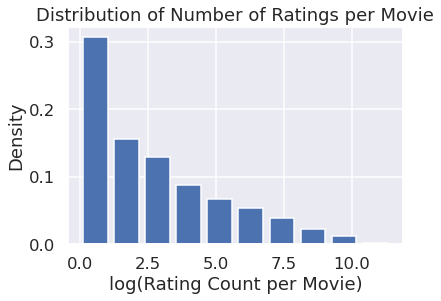

In [26]:
rating_count_per_movie = np.log(ratings_df['Movie ID'].value_counts().values)

plt.hist(rating_count_per_movie, density=True, rwidth=0.8)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('log(Rating Count per Movie)')
plt.ylabel('Density')
plt.show()

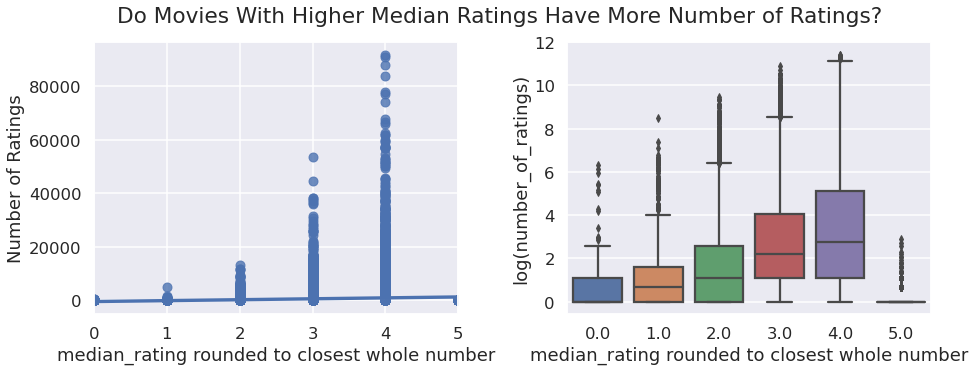

Linear Regression Results
Coefficient: 342
P-Val: 0


In [27]:
rating_per_number_of_ratings = ratings_df.groupby('Movie ID').agg({'User ID': 'count', 'rating': 'median'})
rating_per_number_of_ratings = rating_per_number_of_ratings.rename(columns={'User ID': 'number_of_ratings', 'rating': 'median_rating'})
rating_per_number_of_ratings = np.round(rating_per_number_of_ratings)

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Do Movies With Higher Median Ratings Have More Number of Ratings?')

sns.regplot(x='median_rating', y='number_of_ratings', data=rating_per_number_of_ratings, ax=axes[0])
axes[0].set_xlabel('median_rating rounded to closest whole number')
axes[0].set_ylabel('Number of Ratings')
slope, intercept, r_value, p_value, std_err = stats.linregress(rating_per_number_of_ratings['median_rating'],rating_per_number_of_ratings['number_of_ratings'])

sns.boxplot(x=rating_per_number_of_ratings["median_rating"], y=np.log(rating_per_number_of_ratings["number_of_ratings"]), ax=axes[1])
axes[1].set_xlabel('median_rating rounded to closest whole number')
axes[1].set_ylabel('log(number_of_ratings)')

plt.show()
print('Linear Regression Results\nCoefficient: %d\nP-Val: %d' % (slope, p_value))

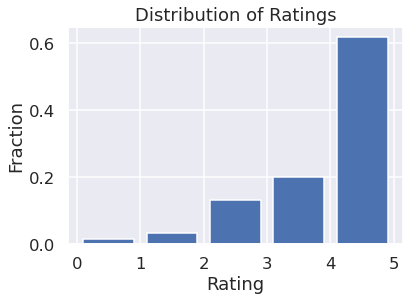

In [28]:
plt.hist(ratings_df['rating'].round(), density=True, rwidth=0.8, bins=5)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Fraction')
plt.show()

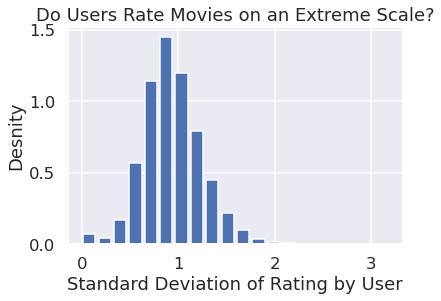

array([3.88066084, 3.65647289, 3.62625258, 2.75979863, 2.46689271,
       4.94530749, 3.36164839, 4.22184227, 4.09035463, 3.95116808])

In [29]:
std_of_rating_by_user = ratings_df.groupby('User ID')['rating'].agg(np.std)
plt.hist(std_of_rating_by_user, bins=20, density=True, rwidth=0.8)
plt.title('Do Users Rate Movies on an Extreme Scale?')
plt.xlabel('Standard Deviation of Rating by User')
plt.ylabel('Desnity')
plt.show()

np.random.normal(loc=3, scale=std_of_rating_by_user.median(), size=10)

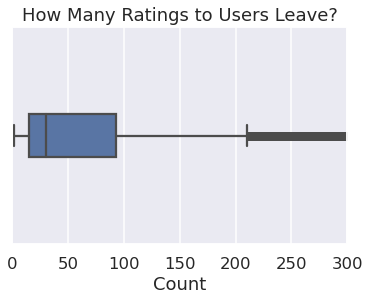

In [30]:
number_of_ratings_per_user = ratings_df.groupby('User ID')['rating'].count().values
ax = sns.boxplot(x=number_of_ratings_per_user, width=0.2)
ax.set_xlim([0, 300])
plt.title("How Many Ratings to Users Leave?")
plt.xlabel("Count")
plt.show()

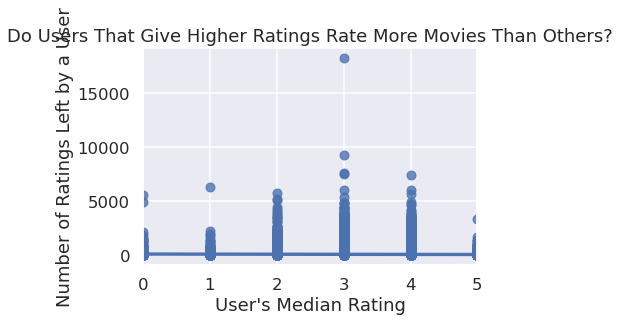

Linear Regression Results
Coefficient: -8
P-Val: 0


In [31]:
rating_count = ratings_df.groupby('User ID')['rating'].agg(['count', np.median])
rating_count['median'] = rating_count['median'].round()

sns.regplot(x="median", y="count", data=rating_count);
plt.title('Do Users That Give Higher Ratings Rate More Movies Than Others?')
plt.xlabel('User\'s Median Rating')
plt.ylabel('Number of Ratings Left by a User')
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(rating_count['median'],rating_count['count'])
print('Linear Regression Results\nCoefficient: %d\nP-Val: %d' % (slope, p_value))

In [8]:
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import dump

In [4]:
reader = Reader()

In [8]:
data = Dataset.load_from_df(ratings_df[['User ID', 'Movie ID', 'rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7965  0.7962  0.7956  0.7962  0.7960  0.7961  0.0003  
MAE (testset)     0.6023  0.6025  0.6019  0.6023  0.6021  0.6022  0.0002  
Fit time          685.16  694.63  693.42  692.81  695.55  692.31  3.70    
Test time         57.71   58.90   49.77   49.97   46.38   52.54   4.88    


{'test_rmse': array([0.79654272, 0.79619573, 0.79561253, 0.79622099, 0.79598232]),
 'test_mae': array([0.60225976, 0.60245458, 0.60187422, 0.6023217 , 0.6021279 ]),
 'fit_time': (685.1593697071075,
  694.6251404285431,
  693.4244229793549,
  692.8122618198395,
  695.5460493564606),
 'test_time': (57.705753564834595,
  58.895099401474,
  49.7657413482666,
  49.96788167953491,
  46.383798360824585)}

In [9]:
training_data = data.build_full_trainset()
algo.fit(training_data)

In [11]:
algo.predict(1, 302, 3)

# check if the algorithm outputs 

Prediction(uid=1, iid=302, r_ui=3, est=4.262429134519651, details={'was_impossible': False})

In [ ]:
# Dump algorithm to save 
file_name = "SVD_model_ex"
dump.dump(file_name, algo=algo)

#### Reload Collaboraitve Filtering Model

In [9]:
# reload algorithm
from surprise import dump
file_name = "SVD_model_ex"
_, loaded_algo = dump.load(file_name)

In [10]:
# uid = user ID
# iid = item id 
# rui = true rating -- optional
pred1 = loaded_algo.predict(1, 302, 3)
rating1 = pred1.est
rating1

4.262429134519651

### Hybrid Recommender

Hybrid Recommender combining content based model and collaborative filtering model. Going to input the User ID and title of the movie and return top 20 movies that are similar based on both the metadata of the input movie and the user's preferences and predicted ratings of those movies.

In [11]:
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
0,461257,tt6980792,Queerama,NaN,[],en,['en'],2017-06-09,75.0,NaN,...,['United Kingdom'],0.163015,NaN,NaN,[],[],daisyasquith,NaN,NaN,daisyasquith
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,...,[],0.326500,NaN,NaN,[],"['michaelontkean', 'raysharkey', 'margotkidder']",paulmazursky,paulmazursky,NaN,paulmazursky paulmazursky michaelontkean rays...
2,114838,tt0029949,Brother Rat,NaN,['Comedy'],en,['en'],1938-10-29,87.0,NaN,...,['United States of America'],0.174691,NaN,NaN,['basedonplayormusical'],"['ronaldreagan', 'janewyman', 'priscillalane',...",williamkeighley,jerrywald,NaN,williamkeighley jerrywald Comedy ronaldreagan...
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,...,[],0.000115,NaN,NaN,[],[],gérardblain,NaN,NaN,gérardblain
4,88061,tt0055459,"So Evil, So Young",NaN,['Drama'],en,['en'],1963-01-01,77.0,NaN,...,[],0.001662,NaN,NaN,"['prison', ""women'sprison""]","['jillireland', 'ellenpollock', 'joanhaythorne...",godfreygrayson,markgrantham,NaN,godfreygrayson markgrantham Drama jillireland...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42273,24428,tt0848228,The Avengers,theavengerscollection,"['Science Fiction', 'Action', 'Adventure']",en,['en'],2012-04-25,143.0,1.519558e+09,...,['United States of America'],89.887648,12000.0,7.4,"['newyork', 'shield', 'marvelcomic', 'superher...","['robertdowneyjr.', 'chrisevans', 'markruffalo...",josswhedon,josswhedon,stanlee,josswhedon josswhedon stanlee theavengerscolle...
42274,19995,tt0499549,Avatar,avatarcollection,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,"['en', 'es']",2009-12-10,162.0,2.787965e+09,...,"['United States of America', 'United Kingdom']",185.070892,12114.0,7.2,"['cultureclash', 'future', 'spacewar', 'spacec...","['samworthington', 'zoesaldana', 'sigourneywea...",jamescameron,jamescameron,jamescameron,jamescameron jamescameron jamescameron avatarc...
42275,155,tt0468569,The Dark Knight,thedarkknightcollection,"['Drama', 'Action', 'Crime', 'Thriller']",en,"['en', 'zh']",2008-07-16,152.0,1.004558e+09,...,"['United Kingdom', 'United States of America']",123.167259,12269.0,8.3,"['dccomics', 'crimefighter', 'secretidentity',...","['christianbale', 'michaelcaine', 'heathledger...",christophernolan,christophernolan,charlesroven,christophernolan christophernolan charlesroven...
42276,27205,tt1375666,Inception,NaN,"['Action', 'Thriller', 'Science Fiction', 'Mys...",en,['en'],2010-07-14,148.0,8.255328e+08,...,"['United Kingdom', 'United States of America']",29.108149,14075.0,8.1,"['lossoflover', 'dream', 'kidnapping', 'sleep'...","['leonardodicaprio', 'josephgordon-levitt', 'e...",christophernolan,christophernolan,christophernolan,christophernolan christophernolan christophern...


In [69]:
movies_ID_map = pd.read_csv("Movies Data/links.csv")[['movieId', 'tmdbId']]
movies_ID_map.columns = ['Movie ID', 'ID']

# drop movies with no ID
movies_ID_map = movies_ID_map.dropna(subset=["ID"])
movies_ID_map["ID"] = movies_ID_map["ID"].astype(int)

# drop duplicates 
movies_ID_map = movies_ID_map.drop_duplicates(subset=["ID"])
movies_ID_map

,Movie ID,ID
0,1,862
1,2,8844
2,3,15602
3,4,31357
4,5,11862
...,...,...
45838,176269,439050
45839,176271,111109
45840,176273,67758
45841,176275,227506


In [70]:
movies_titles = movies_df[["Title", "ID"]]

# drop any null values
movies_titles = movies_titles.dropna()
movies_titles["ID"] = movies_titles["ID"].astype(str).astype(int)

# merge to create a map between the movie ID and tmdb ID and movie title
#movies_titles = movies_titles.merge(movie_ID_map, how="left", on="ID")
movies_ID_map = movies_titles.merge(movies_ID_map, how="left", on="ID")
movies_ID_map

,Title,ID,Movie ID
0,Queerama,461257,176279
1,Willie and Phil,92323,112577
2,Brother Rat,114838,112548
3,Le pélican,264723,112510
4,"So Evil, So Young",88061,112467
...,...,...,...
42272,Deadpool,293660,122904
42273,The Avengers,24428,89745
42274,Avatar,19995,72998
42275,The Dark Knight,155,58559


In [76]:
# save movies ID map to csv file 
outfile = "movies_ID_map.csv"
movies_ID_map.to_csv(outfile, index=False)

#### Hybrid Recommender combining Content Based and Collaborative Filtering Models

In [12]:
# read in movies ID map csv file
movies_ID_map = pd.read_csv("movies_ID_map.csv")
movies_ID_map

,Title,ID,Movie ID
0,Queerama,461257,176279
1,Willie and Phil,92323,112577
2,Brother Rat,114838,112548
3,Le pélican,264723,112510
4,"So Evil, So Young",88061,112467
...,...,...,...
42272,Deadpool,293660,122904
42273,The Avengers,24428,89745
42274,Avatar,19995,72998
42275,The Dark Knight,155,58559


In [13]:
movies_ID_map.loc[movies_ID_map["Title"] == "The Viking"]

,Title,ID,Movie ID
1352,The Viking,99080,82017


In [14]:
# optional -- don't need it for current implementation
indices_map = movies_ID_map.set_index('ID')

In [15]:
# WORKING RECOMMENDER
def hybrid_recommender(userID, title):
    index = indices[title]
    tmdbId = movies_ID_map.loc[movies_ID_map["Title"] == title]['ID']
    movie_id = movies_ID_map.loc[movies_ID_map["Title"] == title]['Movie ID']
    
    # take top 25 movies based on similarity scores to calculate the vote of the 60th percentile movie
    # then calculate the weighted rating of each movie using IMDB formula 
    sim_scores = list(enumerate(cosine_sim_loaded[int(index)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    similar_movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_df.iloc[similar_movie_indices][['Title', 'Vote Count', 'Vote Average', 'ID']]
    similar_movies_IDs = list(map(int, movies["ID"].values))

    for ID, index in zip(similar_movies_IDs, similar_movie_indices):
        #movieID = indices_map.loc[ID]["Movie ID"]
        movieID = int(movies_ID_map.loc[movies_ID_map["ID"] == ID]['Movie ID'])
        est_rating = loaded_algo.predict(userID, movieID).est
        movies.loc[index, "est"] = est_rating
        
    movies = movies.sort_values('est', ascending=False)
    return movies

In [16]:
hybrid_recommender(500, 'The Viking')

,Title,Vote Count,Vote Average,ID,est
10496,Cowards Bend the Knee,3.0,8.0,17595,4.884258
16324,Fighter,6.0,4.7,15930,4.777571
3754,Bardelys the Magnificent,1.0,8.0,128899,4.690357
32345,Samurai X: Trust & Betrayal,41.0,7.7,31501,4.689372
23695,North Shore,13.0,5.2,22915,4.623815
8655,The Rainbow,3.0,6.3,41945,4.616355
6657,Jungle,2.0,4.5,166255,4.610218
92,The Bridal Party in Hardanger,NaN,NaN,102024,4.592057
16948,Stormy Waters,7.0,6.4,64897,4.552303
2949,Room 314,1.0,4.0,60002,4.551811


In [17]:
hybrid_recommender(35, 'The Avengers')

,Title,Vote Count,Vote Average,ID,est
41411,Serenity,1287.0,7.4,16320,4.361905
42269,Guardians of the Galaxy,10014.0,7.9,118340,4.351965
38776,Dr. Horrible's Sing-Along Blog,236.0,7.8,14301,4.268296
42206,Doctor Strange,5880.0,7.1,284052,4.153873
42262,Iron Man,8951.0,7.4,1726,4.126833
36165,Team Thor,93.0,7.5,413279,4.112717
32729,Marvel Studios: Assembling a Universe,44.0,6.6,259910,4.099205
42248,Captain America: Civil War,7462.0,7.1,271110,4.091808
42272,Deadpool,11444.0,7.4,293660,4.054944
42216,Ant-Man,6029.0,7.0,102899,4.043048


In [18]:
hybrid_recommender(10, 'The Avengers')

,Title,Vote Count,Vote Average,ID,est
42262,Iron Man,8951.0,7.4,1726,4.358564
36165,Team Thor,93.0,7.5,413279,4.226156
41411,Serenity,1287.0,7.4,16320,4.225701
42269,Guardians of the Galaxy,10014.0,7.9,118340,4.225263
42248,Captain America: Civil War,7462.0,7.1,271110,4.222177
38776,Dr. Horrible's Sing-Along Blog,236.0,7.8,14301,4.219345
42272,Deadpool,11444.0,7.4,293660,4.203255
32729,Marvel Studios: Assembling a Universe,44.0,6.6,259910,4.160966
560,Thor: Ragnarok,NaN,NaN,284053,4.119349
42263,Iron Man 3,8951.0,6.8,68721,4.054722


In [19]:
hybrid_recommender(35, 'Mean Girls')

,Title,Vote Count,Vote Average,ID,est
31692,Puella Magi Madoka Magica the Movie Part III: ...,36.0,7.3,212162,4.404914
41111,The Edge of Seventeen,952.0,7.3,376660,3.993368
14299,Live from New York!,5.0,5.4,334328,3.952208
33221,Monkey Kingdom,48.0,6.4,295592,3.853414
39153,16 Wishes,283.0,5.5,40205,3.583102
35695,Frenemies,83.0,5.2,84105,3.521542
39125,It's a Boy Girl Thing,279.0,6.3,37725,3.472875
34656,Just One of the Guys,64.0,6.4,24548,3.401603
38215,Geek Charming,188.0,6.0,81250,3.387064
35099,How to Build a Better Boy,71.0,5.7,286987,3.364189


In [20]:
hybrid_recommender(10, 'Mean Girls')

,Title,Vote Count,Vote Average,ID,est
31692,Puella Magi Madoka Magica the Movie Part III: ...,36.0,7.3,212162,4.394826
41111,The Edge of Seventeen,952.0,7.3,376660,4.147640
14299,Live from New York!,5.0,5.4,334328,3.755567
34656,Just One of the Guys,64.0,6.4,24548,3.754710
33221,Monkey Kingdom,48.0,6.4,295592,3.747381
38215,Geek Charming,188.0,6.0,81250,3.725091
39153,16 Wishes,283.0,5.5,40205,3.705147
28333,Screwballs,22.0,4.7,25164,3.665975
35695,Frenemies,83.0,5.2,84105,3.548348
39125,It's a Boy Girl Thing,279.0,6.3,37725,3.443764
